In [1]:
import yaml

# Load the YAML config
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [106]:
import nltk
from nltk.tokenize import TweetTokenizer
import re
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
# Make sure stopwords are downloaded once
nltk.download('stopwords')
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sunai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
def clean_tokens(tokens, keep_mentions=False):
    stop_words = set(stopwords.words('english'))
    cleaned = []

    for token in tokens:
        token_lower = token.lower()

        # Optional: keep mentions like @Google
        if token.startswith('@') and keep_mentions:
            cleaned.append(token_lower)
            continue
        elif token.startswith('@'):
            continue

        # Remove URLs
        if re.match(r'http\S+', token):
            continue

        # Remove hashtags (keep word only)
        if token.startswith('#'):
            token = token[1:]

        # Remove punctuation-only tokens
        if re.match(r'^[\W_]+$', token):
            continue

        # Remove stopwords
        if token_lower in stop_words:
            continue

        cleaned.append(token_lower)
    
    return cleaned


In [48]:
def extract_conll_sentences(filepath):
    sentences = []
    tokens = []

    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sentences.append(tokens)
                    tokens = []
            else:
                parts = line.split()
                if len(parts) == 2:
                    token, _ = parts  # We skip the tag for Gensim
                    tokens.append(token)
    return sentences

In [71]:
def prepare_gensim_sentences(sentences, keep_mentions=False):
    return [clean_tokens(sentence, keep_mentions=keep_mentions) for sentence in sentences]

In [72]:
train_path = config["data"]["train_path"]
test_path = config["data"]["test_path"]

In [73]:
raw_sentences = extract_conll_sentences(train_path)
gensim_sentences = prepare_gensim_sentences(raw_sentences, keep_mentions=False)

In [80]:
unique_words = set(word for sentence in gensim_sentences for word in sentence)
vocab_size = len(unique_words)
print(f"Number of unique words: {vocab_size}")

Number of unique words: 7236


In [81]:
# Initialize and train the model
w2v_model = Word2Vec(
    sentences=gensim_sentences,
    vector_size=7236,     # Size of word embeddings
    window=5,            # Context window size
    min_count=2,         # Ignore words with frequency < 2
    workers=4,           # Use 4 threads for training
    sg=1                 # 1 for skip-gram, 0 for CBOW
)

In [82]:
# Save model to disk
w2v_model.save("models/twitter_word2vec.model")

# Later load it
w2v_model = Word2Vec.load("models/twitter_word2vec.model")

In [110]:
words = list(w2v_model .wv.index_to_key)  # vocabulary words
word_vectors = w2v_model .wv[words]       # corresponding embeddings

In [117]:
n_clusters = 10  # You can experiment with 5–15
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(word_vectors)

In [118]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
word_vectors_2d = tsne.fit_transform(word_vectors)

c:\Users\sunai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


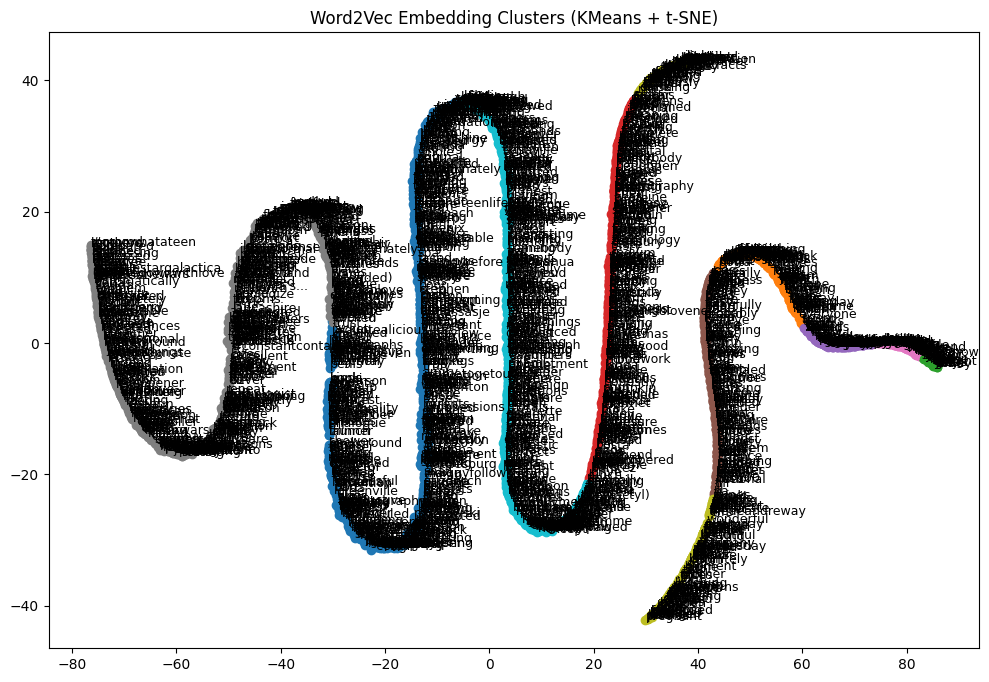

In [119]:
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(cluster_labels / max(cluster_labels))  # assign color to cluster

for i, (x, y) in enumerate(word_vectors_2d):
    plt.scatter(x, y, color=colors[i])
    plt.text(x + 0.001, y + 0.001, words[i], fontsize=9)

plt.title("Word2Vec Embedding Clusters (KMeans + t-SNE)")
plt.show()


1. Clearly Separated color Bands
Distinct curved “bands” — likely due to how t-SNE lays out high-dimensional clusters.

This means clusters are semantically strong — KMeans found meaningful groupings.

2. Dense Regions
Certain zones are densely packed with words, indicating:

Very frequent/common tokens.

Words that are used in similar tweet contexts (e.g., greetings, time references, sentiments).

3. 10 Color-coded Clusters

In [120]:
from collections import defaultdict

cluster_to_words = defaultdict(list)
for word, label in zip(words, cluster_labels):
    cluster_to_words[label].append(word)

for cluster_id, word_list in cluster_to_words.items():
    print(f"Cluster {cluster_id}: {word_list}")  # Top 15

Cluster 2: ['rt', "'s", 'day', 'time', 'today', 'tonight', 'get', 'week', 'like', 'one', 'know', '&amp;', '2', 'got', 'days', 'years', 'may', 'year', 'long', 'im', '&quot;', '2010']
Cluster 6: ['u', 'tomorrow', 'go', 'friday', 'lol', 'good', '&lt;', 'love', 'going', '3', 'night', 'next', 'see', 'back', 'new', 'last', 'well', 'need', 'sunday', 'come', 'people', 'want', 'work', 'think', ':d', 'make', 'home', 'say', 'first', 'hope', 'would', 'school', 'really', 'show', 'oh', 'weekend', 'life', 'even', 'great', 'still', 'let', 'right', 'much', '1', 'us', 'ago', 'n', '4', 'try', "can't", 'twitter', 'party', 'said', 'weeks', 'way', 'justin']
Cluster 4: ['happy', 'game', 'every', 'gonna', 'better', 'free', 'check', 'haha', 'made', 'follow', 'ur', 'wait', 'take', 'birthday', 'best', 'saturday', 'hate', 'sleep', 'please', "n't", 'always', 'start', 'big', 'look', 'someone', '&gt;', 'around', 'ready', 'x', 'yeah', 'tonite', 'feel', 'live', 'two', 'never', 'via', 'bad', "'m", 'excited', 'yes', 'do

Cluster	Sample Words	Label
Cluster 2	rt, day, today, tonight, week, years, get	            🌐 Time & Common Twitter Terms – includes temporal references and very      frequent tokens

Cluster 6	tomorrow, friday, lol, good, love, sunday, school	🗓️ Weekly Time + Sentiment – days of the week mixed with positive or casual expressions

Cluster 4	happy, game, birthday, excited, thanks, saturday, music	🎉 Celebration/Social Events – words linked to happy events, celebrations, or social activities

Cluster 1	coming, morning, awesome, yesterday, omg, miss, sorry	😍 Emotion + Time – a mix of temporal words with emotional tone

Cluster 5	win, tired, lmao, damn, love, movie, london	🎭 Entertainment & Reactions – humor, emotion, places, and pop culture

Cluster 8	football, festival, gym, family, event, pregnant, doctor, park, jfk	🏙️ Activities & Locations – events, health, and places like jfk airport

Cluster 3	goin, song, goodnight, girl, york, peace, drunk, nyc	🌆 Nightlife & Places – informal speech, partying, and urban locations

Cluster 9	sweet, hurt, shopping, sushi, paris, winter, country, miami, anniversary	🌍 Feelings & Travel – emotions, food, travel destinations, and special occasions

Cluster 0	coffee, canada, phoenix, angry, sunny, reuters, media	📌 General Daily Life & Media – news sources, weather, sentiment, and locations

Cluster 7	vacation, fire, style, south, jets, vancouver, deadline, england	✈️ Travel & Lifestyle – destinations, time phrases, sports, and lifestyle events



### 🚫 Inferences of Word2Vec model:

1. **Lack of Context Awareness**

   * Word2Vec generates a **single static vector per word**, regardless of its usage.
   * Words like `"game"`, `"light"`, `"cold"` have multiple meanings but only one embedding → leads to **semantic overlap** in clusters.

2. **Overlapping and Ambiguous Clusters**

   * Many clusters contain words that fit in **multiple topics**, causing **unclear or fuzzy boundaries**.
   * Emotion words (`love`, `miss`, `today`) appear in several clusters.

3. **Dominance of High-Frequency Words**

   * Frequent and generic words (e.g., `today`, `good`, `love`) **dominate cluster centers**, overshadowing more meaningful but rarer terms.

4. **Clusters Not Easily Interpretable**

   * Clusters don't map cleanly to distinct themes (e.g., emotion, location, activity).
   * Difficult to assign **human-readable labels** due to semantic mixing.

5. **Ignores Word Order and Syntax**

   * Word2Vec doesn’t capture **phrases or grammar**, so `"cold war"` and `"cold drink"` are treated similarly to just `"cold"`.

6. **Word-Level Clustering Limitation**

   * Clustering individual words rather than full tweets or phrases **ignores full message context**.
   * This reduces the model's utility in content or user-level insights.

---

### 💡 Better Alternatives (Briefly):

* **Contextual embeddings** (BERT, RoBERTa): Capture word meaning based on sentence.
* **Sentence-level clustering**: Cluster entire tweets, not just words.
* **HDBSCAN + UMAP**: Better separation and visualization of clusters.

---